# DSA simulations

In [1]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
import glob, os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 2.5 * matplotlib.rcParams['figure.dpi']

import astropy
from astropy.time import Time

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions import models, model_utils

import libstempo as T2, libstempo.toasim as LT, libstempo.plot as LP
from ephem import Ecliptic, Equatorial

datadir = '../partim_no_noise/'

You'll need sksparse for get_coefficients() with common signals!


In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

#plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}',r'\usepackage{amsbsy}',
                                r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}
plt.rcParams.update(params)

## Useful functions

In [3]:
import pandas as pd

In [4]:
# Get (equatorial) position of pulsars from name
def pos_from_name(name):
    pos = []
    for p in name:
        if '+' in p:
            tmp = p.split('+')
            raj = '{0}:{1}:00.00'.format(tmp[0][1:3],tmp[0][3:])
            decj = '+{0}:{1}:00.00'.format(tmp[1][:2],tmp[1][2:])
        else:
            tmp = p.split('-')
            raj = '{0}:{1}:00.00'.format(tmp[0][1:3],tmp[0][3:])
            decj = '-{0}:{1}:00.00'.format(tmp[1][:2],tmp[1][2:])

        eq = Equatorial(raj, decj)
        if 'B' in p: epoch = '1950'
        elif 'J' in p: epoch= '2000'
        ec = Ecliptic(eq, epoch=str(epoch))
        pos.append([float(eq.ra), float(eq.dec)])
    
    return np.array(pos)

# Get name of pulsar from (equatorial) position
def name_from_pos(pos):
    name = []
    for p in pos:
        eq = Equatorial(p[0], p[1])
        ra = str(eq.ra) 
        dec = str(eq.dec)
        #
        if float(ra.split(':')[0]) < 10:
            ra = '0' + ''.join(ra.split(':')[:2])
        else:
            ra = ''.join(ra.split(':')[:2])
        #
        if np.abs(float(dec.split(':')[0])) < 10:
            dec = ':'.join(['-0'+dec.split(':')[0][1:],dec.split(':')[1]])
        else:
            dec = ':'.join(dec.split(':')[:2])
        if float(dec.split(':')[0]) < 0:
            dec = ''.join(dec.split(':')[:2])
        elif float(dec.split(':')[0]) > 0:
            dec = '+' + ''.join(dec.split(':')[:2])
        else:
            dec = ''.join(dec.split(':')[:2])
        #
        name.append('J' + ra + dec)
    
    return np.array(name)

In [5]:
# Draw new random positions based on a sample
def invtran_sample(pos, size):
    x, y = pos[:,0], pos[:,1]                     
    hist, xbin, ybin = np.histogram2d(x, y, bins=(10, 10))
    xbinc = xbin[:-1] + np.diff(xbin)/2.0
    ybinc = ybin[:-1] + np.diff(ybin)/2.0
    cdf = np.cumsum(hist.ravel())
    cdf = cdf / cdf[-1]

    values = np.random.rand(size)
    value_bins = np.searchsorted(cdf, values)
    x_idx, y_idx = np.unravel_index(value_bins,
                                    (len(xbinc),
                                     len(ybinc)))
    delta_x = np.diff(xbin)[0]
    delta_y = np.diff(ybin)[0]
    if size == 1:
        random_from_cdf = [xbinc[x_idx][0] + np.random.uniform(-delta_x/2.0, delta_x/2.0),
                           ybinc[y_idx][0] + np.random.uniform(-delta_y/2.0, delta_y/2.0)]
    else:
        random_from_cdf = np.column_stack((xbinc[x_idx] + np.random.uniform(-delta_x/2.0, delta_x/2.0),
                                           ybinc[y_idx] + np.random.uniform(-delta_y/2.0, delta_y/2.0)))
    
    return random_from_cdf

In [6]:
def year2mjd(year):
    # rounds to nearest year
    return float(Time("{}-01-01T00:00:00".format(str(int(np.rint(year)))), 
                      format='isot').mjd)

def mjd2year(mjd):
    return float(Time(mjd, format='mjd').decimalyear)

## Process data

In [51]:
data = pd.read_csv('../data/v2/RMSonlyvsTime2018-DSA2000-LoseAO.csv',header=0,skip_blank_lines=True,)

In [52]:
# Correcting for mistake in spreadsheet
for ii,name in data.iterrows():
    print name
    #if name.Observatory == 'GBT' and name.PSR == 'NEWPSR' and name.Epoch2 >= 2025:
    #    data.iloc[ii,6] = name.RMS3
    #    data.iloc[ii,7] = np.nan
    #    data.iloc[ii,8] = np.nan

PSR                   J0340+4130
Observatory                  GBT
Nepochs                        4
Epoch1                      2005
RMS1                         NaN
Epoch2                      2012
RMS2                     1.07709
Epoch3                      2020
RMS3           0.539008403111635
Epoch4                      2025
RMS4           0.208076981298729
Epoch5                       NaN
RMS5                         NaN
Name: 0, dtype: object
PSR                   J0605+3757
Observatory                  GBT
Nepochs                        4
Epoch1                      2005
RMS1                         NaN
Epoch2                      2017
RMS2                     2.08495
Epoch3                      2020
RMS3            1.04260997170732
Epoch4                      2025
RMS4           0.399110135472023
Epoch5                       NaN
RMS5                         NaN
Name: 1, dtype: object
PSR                   J0610-2100
Observatory                  GBT
Nepochs                       

In [44]:
# names of all real gbt and ao pulsars
real_pulsars_gbt = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' not in name.PSR and name.Observatory=='GBT'])
real_pulsars_ao = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' not in name.PSR and name.Observatory=='AO'])

# names of all fake gbt and ao pulsars (these are all NEWPSR)
fake_pulsars_gbt = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' in name.PSR and name.Observatory=='GBT'])
fake_pulsars_ao = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' in name.PSR and name.Observatory=='AO'])

In [45]:
# Get equatorial positions (ra, dec...in radians) from names
pos_pulsars_gbt = pos_from_name(real_pulsars_gbt)
pos_pulsars_ao = pos_from_name(real_pulsars_ao)

In [46]:
# Generate new fake pulsar positions
fakepos_pulsars_gbt = np.array([invtran_sample(pos_pulsars_gbt, size=1) for ii in range(len(fake_pulsars_gbt))])
fakepos_pulsars_ao = np.array([invtran_sample(pos_pulsars_ao, size=1) for ii in range(len(fake_pulsars_ao))])

# Generate new fake pulsar names
fake_pulsars_gbt = name_from_pos(fakepos_pulsars_gbt)
fake_pulsars_ao = name_from_pos(fakepos_pulsars_ao)

In [53]:
# Make copy of data frame and replace NEWPSR with new names

data_copy = data.copy(deep=True)
ct_gbt = 0
ct_ao = 0
for ii,name in data_copy.iterrows():
    
    # New GBT pulsars
    if name.Observatory == 'GBT' and name.PSR=='NEWPSR':
        #tmp_pos = invtran_sample(pos_pulsars_gbt, size=1)
        #tmp_name = name_from_pos(tmp_pos)
        #data_copy.iloc[ii,0] = tmp_name[0]
        data_copy.iloc[ii,0] = fake_pulsars_gbt[ct_gbt]
        ct_gbt += 1
        
    # New AO pulsars
    if name.Observatory == 'AO' and name.PSR=='NEWPSR':
        #tmp_pos = invtran_sample(pos_pulsars_ao, size=1)
        #tmp_name = name_from_pos(tmp_pos)
        #data_copy.iloc[ii,0] = tmp_name[0]
        data_copy.iloc[ii,0] = fake_pulsars_ao[ct_ao]
        ct_ao += 1

In [54]:
# Create new data columns for RAJ and DECJ

data_copy = data_copy.assign(RAJ=pd.Series(np.concatenate([pos_pulsars_gbt[:,0],
                                                           fakepos_pulsars_gbt[:,0],
                                                           pos_pulsars_ao[:,0],
                                                           fakepos_pulsars_ao[:,0]])).values)

data_copy = data_copy.assign(DECJ=pd.Series(np.concatenate([pos_pulsars_gbt[:,1],
                                                           fakepos_pulsars_gbt[:,1],
                                                           pos_pulsars_ao[:,1],
                                                           fakepos_pulsars_ao[:,1]])).values)

In [55]:
# Write to csv
data_copy.to_csv('../data/v2/lose_ao.csv')

In [56]:
data_copy

,PSR,Observatory,Nepochs,Epoch1,RMS1,Epoch2,RMS2,Epoch3,RMS3,Epoch4,RMS4,Epoch5,RMS5,RAJ,DECJ
0,J0340+4130,GBT,4,2005,NaN,2012,1.077091,2020.0,0.539008403111635,2025.0,0.208076981298729,NaN,NaN,0.959931,0.724312
1,J0605+3757,GBT,4,2005,NaN,2017,2.084949,2020.0,1.04260997170732,2025.0,0.399110135472023,NaN,NaN,1.592613,0.662352
2,J0610-2100,GBT,4,2005,NaN,2017,0.996647,2020.0,0.499124992606085,2025.0,0.194321565834343,NaN,NaN,1.614430,-0.366519
3,J0613-0200,GBT,4,2005,0.821077,2010,0.269768,2020.0,0.135509231872431,2025.0,0.054510688085322,NaN,NaN,1.627520,-0.034907
4,J0636+5128,GBT,4,2005,NaN,2014,0.313522,2020.0,0.157803744527495,2025.0,0.0647937188972374,NaN,NaN,1.727876,0.898263
5,J0645+5158,GBT,4,2005,NaN,2011,0.221656,2020.0,0.111234903352832,2025.0,0.0442929147074133,NaN,NaN,1.767146,0.906989
6,J0740+6620,GBT,4,2005,NaN,2014,0.270038,2020.0,0.136249360031899,2025.0,0.0572889319373561,NaN,NaN,2.007129,1.157735
7,J0931-1902,GBT,4,2005,NaN,2013,0.911594,2020.0,0.457314491486353,2025.0,0.181437862100645,NaN,NaN,2.491458,-0.332194
8,J1012+5307,GBT,4,2005,0.679447,2010,0.255525,2020.0,0.129373040631289,2025.0,0.0561472626546997,NaN,NaN,2.670354,0.927061
9,J1012-4235,GBT,4,2005,NaN,2017,3.255745,2020.0,1.62790945122741,2025.0,0.622385266489522,NaN,NaN,2.670354,-0.743219


## Creating par files

In [57]:
sim_type = 'status_quo' # 'status_quo' or 'lose_ao'

In [58]:
# Read from csv
data_copy = pd.read_csv('../data/v2/{}.csv'.format(sim_type))

In [59]:
for ii,name in data_copy.iterrows():
    
    # Get coordinates for par file
    tmp = Equatorial(data_copy.iloc[ii].RAJ, data_copy.iloc[ii].DECJ, epoch='2000')
    
    # Set PEPOCHs to be 5 years in
    rms = np.array([name.RMS1, name.RMS2, name.RMS3, 
                    name.RMS4, name.RMS5])
    rms[rms=='gap'] = np.inf
    rms = np.array(rms,dtype=float)
    epoch = np.array([name.Epoch1, name.Epoch2, name.Epoch3, 
                      name.Epoch4, name.Epoch5])
    start = epoch[np.where(~np.isnan(rms))[0][0]]
    
    with open('../data/template.par', 'r') as fil:
        pardata = fil.read()
        
    with open('../data/v2/par/' + name.PSR + '.par', 'w') as filnew:
        for line in pardata.split('\n'):
            if 'PSR' in line:
                print >>filnew, '\t\t'.join([line.split()[0], name.PSR])
            elif 'RAJ' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(tmp.ra), 
                                         line.split()[2], line.split()[3]])
            elif 'DECJ' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(tmp.dec), 
                                         line.split()[2], line.split()[3]])
            elif 'PEPOCH' in line or 'POSEPOCH' in line or 'DMEPOCH' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(int(year2mjd(start+5)))])
            else:
                print >>filnew, line
    print name.PSR, start

/Users/staylor/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


J0340+4130 2012.0
J0605+3757 2017.0
J0610-2100 2017.0
J0613-0200 2005.0
J0636+5128 2014.0
J0645+5158 2011.0
J0740+6620 2014.0
J0931-1902 2013.0
J1012+5307 2005.0
J1012-4235 2017.0
J1024-0719 2010.0
J1125+7819 2014.0
J1455-3330 2005.0
J1600-3053 2008.0
J1614-2230 2009.0
J1630+3734 2017.0
J1643-1224 2005.0
J1705-1903 2017.0
J1719-1438 2017.0
J1730-2304 2017.0
J1744-1134 2005.0
J1747-4036 2012.0
J1751-2857 2017.0
J1802-2124 2017.0
J1811-2405 2017.0
J1832-0836 2013.0
J1843-1113 2017.0
J1909-3744 2005.0
J1911-1114 2017.0
J1918-0642 2005.0
J2010-1323 2009.0
J2124-3358 2017.0
J2145-0750 2005.0
J2302+4442 2012.0
J1055+4309 2019.0
J1720-1843 2019.0
J1752-2616 2020.0
J1743-3227 2020.0
J1839-2115 2021.0
J0818+6805 2021.0
J1718-1150 2022.0
J1748-1613 2022.0
J1612-4005 2023.0
J1251+6958 2023.0
J0351+3046 2024.0
J0721+5157 2024.0
J0922+7742 2025.0
J1732-3004 2025.0
J0659-2409 2026.0
J0613-051 2026.0
J0612+4818 2027.0
J1747-2750 2027.0
J1801-2435 2028.0
J2226+4454 2028.0
J1520+3530 2029.0
J0842+7324 

## Creating tim files

In [11]:
sim_type = 'lose_ao' # 'status_quo' or 'lose_ao'

In [12]:
# Read from csv
data_copy = pd.read_csv('../data/v2/{}.csv'.format(sim_type))

In [13]:
dsa_sims = []
start_data = []
for jj,name in data_copy.iterrows():
    
    psrname = name.PSR
    
    rms = np.array([name.RMS1, name.RMS2, name.RMS3, 
                    name.RMS4, name.RMS5])
    rms[rms=='gap'] = np.inf
    rms = np.array(rms,dtype=float)
    epoch = np.array([name.Epoch1, name.Epoch2, name.Epoch3, 
                      name.Epoch4, name.Epoch5])
    
    ### Start and End year
    start_yr = epoch[np.where(~np.isnan(rms))[0][0]]
    start_yr_mjd = year2mjd(start_yr)
    #
    end_yr = 2045
    end_yr_mjd = year2mjd(end_yr)
    
    ### Spacing and obstimes
    spacing = 365.25 / 20.0 # days between observations
    #
    obstimes = np.arange(start_yr_mjd, end_yr_mjd, spacing)
    # removing data gaps
    for kk,rmss in enumerate(rms):
        if np.isinf(rmss):
            mask = np.logical_and(obstimes >= year2mjd(epoch[kk]), 
                                  obstimes <= year2mjd(epoch[kk+1]))
            obstimes = obstimes[~mask]
    
    ### Segmenting obstimes based on hardware/telescope switches
    stops = list(epoch[np.where(~np.isnan(rms))[0]]) + [end_yr]
    stops = [year2mjd(yr) for yr in stops]
    errors = list(rms[np.where(~np.isnan(rms))[0]])
    
    ### Masking sections of data based on these stops
    masks = []
    for kk,stop in enumerate(stops):
        if kk < len(stops)-1:
            masks.append(np.logical_and(obstimes >= stops[kk], 
                                        obstimes <= stops[kk+1]))
    
    ### Applying RMS errors
    toa_errs = np.ones_like(obstimes)
    for kk,mask in enumerate(masks):
        toa_errs[mask] *= float(errors[kk])
    
    ### Make fake dataset
    par = '../data/v2/par/' + psrname + '.par'
    dsa_sims.append(LT.fakepulsar(parfile=par, obstimes=obstimes, 
                                  toaerr=toa_errs, 
                                  observatory=name.Observatory.lower()))
    # white noise
    LT.add_efac(dsa_sims[jj])
    # save .tim
    dsa_sims[jj].savetim('../data/v2/tim_{}/'.format(sim_type) 
                         + dsa_sims[jj].name + '.tim')
    ###
    
    start_data.append([psrname, start_yr, start_yr_mjd])
    print psrname, par, start_yr_mjd, end_yr_mjd, len(stops), len(masks), len(errors)

J0340+4130 ../data/v2/par/J0340+4130.par 55927.0 67981.0 4 3 3
J0605+3757 ../data/v2/par/J0605+3757.par 57754.0 67981.0 4 3 3
J0610-2100 ../data/v2/par/J0610-2100.par 57754.0 67981.0 4 3 3
J0613-0200 ../data/v2/par/J0613-0200.par 53371.0 67981.0 5 4 4
J0636+5128 ../data/v2/par/J0636+5128.par 56658.0 67981.0 4 3 3
J0645+5158 ../data/v2/par/J0645+5158.par 55562.0 67981.0 4 3 3
J0740+6620 ../data/v2/par/J0740+6620.par 56658.0 67981.0 4 3 3
J0931-1902 ../data/v2/par/J0931-1902.par 56293.0 67981.0 4 3 3
J1012+5307 ../data/v2/par/J1012+5307.par 53371.0 67981.0 5 4 4
J1012-4235 ../data/v2/par/J1012-4235.par 57754.0 67981.0 4 3 3
J1024-0719 ../data/v2/par/J1024-0719.par 55197.0 67981.0 4 3 3
J1125+7819 ../data/v2/par/J1125+7819.par 56658.0 67981.0 4 3 3
J1455-3330 ../data/v2/par/J1455-3330.par 53371.0 67981.0 5 4 4
J1600-3053 ../data/v2/par/J1600-3053.par 54466.0 67981.0 5 4 4
J1614-2230 ../data/v2/par/J1614-2230.par 54832.0 67981.0 5 4 4
J1630+3734 ../data/v2/par/J1630+3734.par 57754.0 67981.

/Users/staylor/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':



J0721+5157 ../data/v2/par/J0721+5157.par 60310.0 67981.0 3 2 2
J0922+7742 ../data/v2/par/J0922+7742.par 60676.0 67981.0 2 1 1
J1732-3004 ../data/v2/par/J1732-3004.par 60676.0 67981.0 2 1 1
J0659-2409 ../data/v2/par/J0659-2409.par 61041.0 67981.0 2 1 1
J0613-051 ../data/v2/par/J0613-051.par 61041.0 67981.0 2 1 1
J0612+4818 ../data/v2/par/J0612+4818.par 61406.0 67981.0 2 1 1
J1747-2750 ../data/v2/par/J1747-2750.par 61406.0 67981.0 2 1 1
J1801-2435 ../data/v2/par/J1801-2435.par 61771.0 67981.0 2 1 1
J2226+4454 ../data/v2/par/J2226+4454.par 61771.0 67981.0 2 1 1
J1520+3530 ../data/v2/par/J1520+3530.par 62137.0 67981.0 2 1 1
J0842+7324 ../data/v2/par/J0842+7324.par 62137.0 67981.0 2 1 1
J0801+7318 ../data/v2/par/J0801+7318.par 62502.0 67981.0 2 1 1
J0700+4726 ../data/v2/par/J0700+4726.par 62502.0 67981.0 2 1 1
J0812+6641 ../data/v2/par/J0812+6641.par 62867.0 67981.0 2 1 1
J1751-3449 ../data/v2/par/J1751-3449.par 62867.0 67981.0 2 1 1
J1628+4132 ../data/v2/par/J1628+4132.par 63232.0 67981.0

In [14]:
start_data = np.array(start_data)
start_data[start_data[:,1].argsort()]

fil = open('sims_psr_startdata_{}.txt'.format(sim_type),'w')
for line in start_data[start_data[:,1].argsort()]:
    print >>fil, line[0], line[1], line[2]
fil.close()

# Read In And Check Pulsars

In [15]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import enterprise_extensions
from enterprise_extensions import models, model_utils

In [18]:
psr1 = Pulsar('../data/v2/par/J2234', '../data/v2/tim_status_quo/J1316+1119.tim', ephem='DE436')
psr2 = Pulsar('../data/v2/par/J1316+1119.par', '../data/v2/tim_lose_ao/J1316+1119.tim', ephem='DE436')

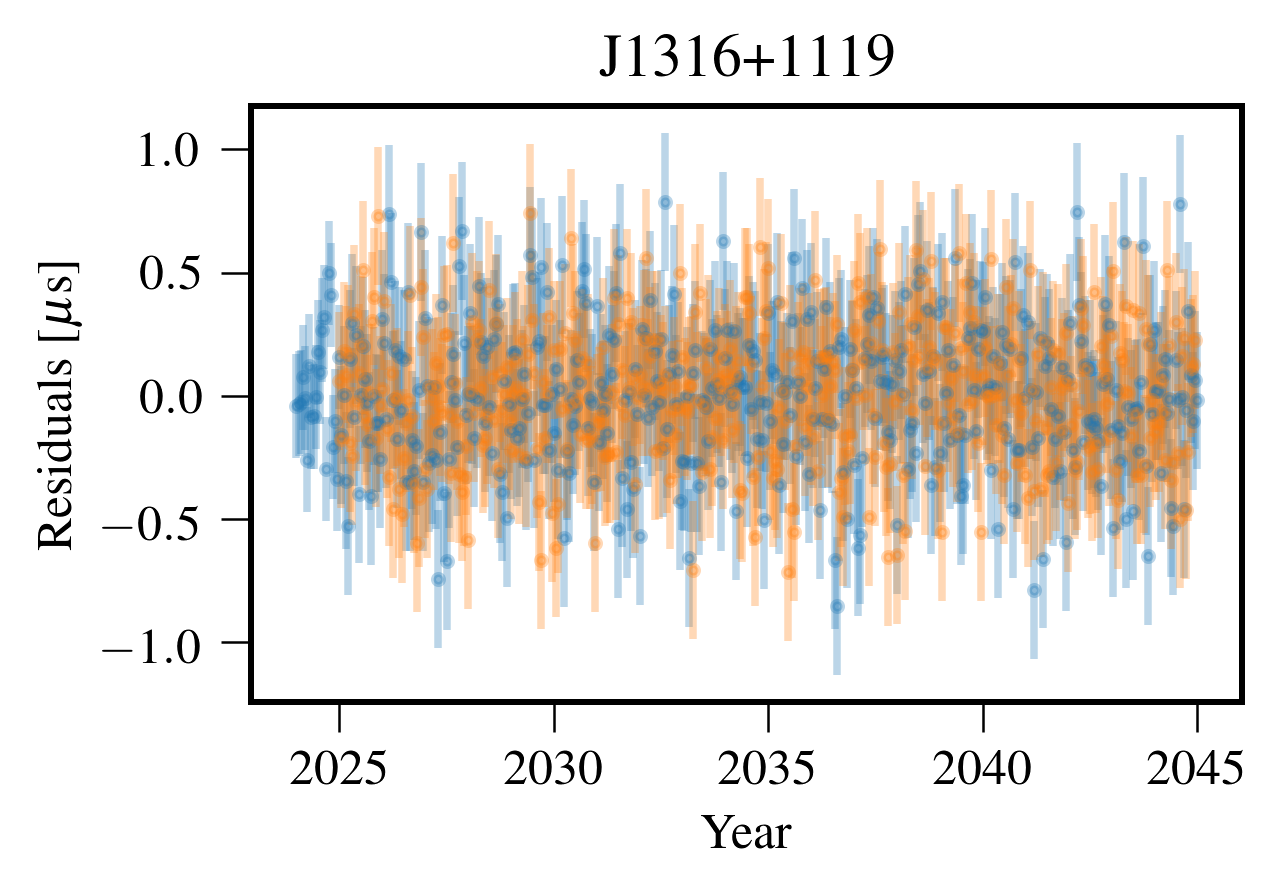

In [19]:
plt.errorbar([mjd2year(p) for p in psr1.toas/86400.0], 
             psr1.residuals/1e-6, psr1.toaerrs/1e-6, 
             alpha=0.3, fmt='.')

plt.errorbar([mjd2year(p) for p in psr2.toas/86400.0], 
             psr2.residuals/1e-6, psr2.toaerrs/1e-6, 
             alpha=0.3, fmt='.')

plt.xlabel(r'Year')
plt.ylabel(r'Residuals [$\mu$s]')
plt.title(psr1.name)